
<h2>Target</h2>
<ul>
<li>Generative (not retrieval)</li>
<li>Small-talk (short convos)</li>
<li>Open Domain</li>
<li>No context</li>
<li>Eval [https://arxiv.org/abs/1603.08023]</li>
</ul>
<h2>Potential Sources of Data</h2>
<ul>
<li>http://files.pushshift.io/reddit/comments/</li>
<li>https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html</li>
<li>https://github.com/Marsan-Ma/twitter_scraper</li>
<li>http://dataset.cs.mcgill.ca/ubuntu-corpus-1.0/</li>
</ul>
<h2>Potential Models</h2>
<h3>This Medium Article</h3>
<ul>
<li>https://medium.com/botsupply/generative-model-chatbots-e422ab08461e</li>
<li>Use high LR, then reduce</li>
<li>Reverse input sentence</li>
<li>50 K vocab</li>
</ul>
<h3>LSTM Encoder Decoder</h3>
<h2></h2>

In [0]:
%cd ..
%cd root
import pandas as pd
df = pd.read_csv("dwdata_2.csv")
df.fillna('', inplace=True)

/
/root


In [0]:
x_1 = df["X_1"].tolist()
y_1 = df["Y_1"].tolist()

import tensorflow_datasets as tfds
# from tensorflow_datasets.features.text.SubwordTextEncoder import build_from_corpus
from tensorflow.keras.preprocessing.sequence import pad_sequences
token_x = tfds.features.text.SubwordTextEncoder.build_from_corpus(x_1, target_vocab_size=1e12)
token_y = tfds.features.text.SubwordTextEncoder.build_from_corpus(y_1, target_vocab_size=1e12)

vocab_size_x = token_x.vocab_size
vocab_size_y = token_y.vocab_size + 2 # adding the start and end characters

inputs = [token_x.encode(sentence) for sentence in x_1]
outputs = [[vocab_size_y - 2] + token_y.encode(sentence) + [vocab_size_y - 1] for sentence in y_1]

MAXLEN = 70
idx_to_shorten = [count for count, sent in enumerate(inputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]
idx_to_shorten = []
idx_to_shorten = [count for count, sent in enumerate(outputs) if len(sent) > MAXLEN]
for idx in idx_to_shorten:
    inputs[idx] = inputs[idx][:MAXLEN]
    outputs[idx] = outputs[idx][:MAXLEN]

MINLEN = 4
idx_to_delete = [count for count, sent in enumerate(inputs) if len(sent) < MINLEN]
for idx in reversed(idx_to_delete):
    del inputs[idx]
    del outputs[idx]
idx_to_delete = []
idx_to_delete = [count for count, sent in enumerate(outputs) if len(sent) < MINLEN]
for idx in reversed(idx_to_delete):
    del inputs[idx]
    del outputs[idx]

inputs = pad_sequences(inputs, value=0, padding="post", maxlen=MAXLEN)
outputs = pad_sequences(outputs, value=0, padding="post", maxlen=MAXLEN)
print("{},{}".format(inputs.shape,outputs.shape))

(9413, 70),(9413, 70)


In [0]:
token_x.decode(np.squeeze(inputs_1[0],axis=-1))

'im pleased you two are so impressed i find the whole placehateful'

In [0]:
import numpy as np
from scipy.ndimage.interpolation import shift
inputs_1 = inputs
inputs_2 = outputs
outputs_1 = outputs
outputs_1 = shift(outputs_1, [0,-1], cval=0)
print("{},{}".format(inputs_1.shape,outputs_1.shape))

(55455, 70),(55455, 70)


In [0]:
print(inputs_1[20,:20])
print(inputs_2[20,:20])
print(outputs_1[20,:20])

[  22    7   24  716   92 3330   17   40  381    3   34  273   50    0
    0    0    0    0    0    0]
[44307    22    14   726    28     4 18915   267  1505    32     4   407
    72     5  1346   646     3    89     5   371]
[   22    14   726    28     4 18915   267  1505    32     4   407    72
     5  1346   646     3    89     5   371  2078]


In [0]:
inputs_1 = np.expand_dims(inputs_1,axis=-1)
inputs_2 = np.expand_dims(inputs_2,axis=-1)
outputs_1 = np.expand_dims(outputs_1,axis=-1)

NameError: ignored

In [0]:
latent_dim = 128
batch_size = 32
epochs = 100

In [0]:
print("{},{}".format(vocab_size_x,vocab_size_y))

37090,44309


In [0]:
#We do the most basic one
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

encoder_inputs = Input(shape=(None,1))
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,1))
decoder_outputs, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
hist = model.fit([inputs_1, inputs_2], outputs_1,batch_size=batch_size,epochs=epochs,validation_split=0.2)
model.save("2nd_m.h5")

Epoch 1/100
1387/1387 [==============================] - 17s 12ms/step - loss: 1.1644e-04 - val_loss: 1.1677e-04
Epoch 2/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1645e-04 - val_loss: 1.1677e-04
Epoch 3/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1646e-04 - val_loss: 1.1677e-04
Epoch 4/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1644e-04 - val_loss: 1.1677e-04
Epoch 5/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1645e-04 - val_loss: 1.1677e-04
Epoch 6/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1645e-04 - val_loss: 1.1677e-04
Epoch 7/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1644e-04 - val_loss: 1.1677e-04
Epoch 8/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1645e-04 - val_loss: 1.1677e-04
Epoch 9/100
1387/1387 [==============================] - 16s 12ms/step - loss: 1.1645e-04 - val_

The model might have a case of vanishing gradient problem, and it's underfitting (plateauing loss) --> increase cells / increase layers

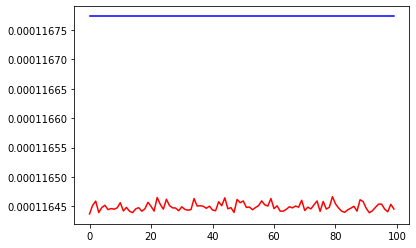

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"], color="r")
plt.plot(hist.history["val_loss"], color="b")

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True)(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

In [0]:
def decode_sequence(input_seq):
    input_seq = np.expand_dims(input_seq,axis=-1)
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1,1))
    target_seq[0, 0, 0] = vocab_size_y - 2

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = output_tokens[:,-1,:]
        decoded_sentence.append(sampled_token_index[0][0])

        if (sampled_token_index == vocab_size_y - 1 or len(decoded_sentence) > MAXLEN):
            stop_condition = True

        target_seq = np.zeros((1,1,1))
        target_seq[0,0,0] = sampled_token_index
        states_value = [h, c]
    pred = token_y.decode([int(i) for i in decoded_sentence])
    return pred
index_try = 33
input_seq = inputs_1[index_try: index_try + 1]
pred = decode_sequence(input_seq)
print('-')
print('Input sentence:', token_x.decode(np.squeeze(inputs_1[index_try], axis=-1)))
print('Decoded sentence:', pred)

-
Input sentence: ill just fetch my galoshes
Decoded sentence: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


In [0]:

#https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnp-6f355f3e5639
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
encoder_embedding = embed_layer(encoder_inputs)
encoder_LSTM = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
decoder_embedding = embed_layer(decoder_inputs)
decoder_LSTM = LSTM(128, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

outputs = TimeDistributed(Dense(20000, activation='softmax'))(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])